# Работа 2. Решение СЛАУ

Рассматривается система линейных алгебраических уравнений (СЛАУ)

$$
A x = b,\qquad A\in\mathbb{R}^{n\times n},\ x,b\in\mathbb{R}^n.
$$

В лабораторной сравниваются **прямые методы** (дают ответ за конечное число шагов) и **итерационные методы** (строят последовательность приближений).

## Мера точности: невязка

Если $x_k$ — приближённое решение, то **вектор невязки**

$$
r_k = b - A x_k.
$$

Обычно смотрят, как убывает норма $\|r_k\|_2$.  
Для удобства будем использовать **относительную невязку**

$$
\frac{\|r_k\|_2}{\|b\|_2}.
$$

Для итерационных методов будем строить графики убывания невязки по номеру итерации.

## Методы, которые реализуем

**Прямые:**
1) Метод Гаусса с выбором главного элемента (частичный выбор).  
2) LU-разложение с перестановками ($PA=LU$), если применимо.

**Итерационные:**

3) Метод Якоби.  
4) Метод Зейделя (Гаусса—Зейделя).  
5) Метод верхней релаксации (SOR).  
6) Градиентный спуск (для задачи наименьших квадратов).  
7) Метод минимальных невязок (MR).  
8) Сопряжённые градиенты на нормальных уравнениях (CGNR) и BiCGSTAB.


## Пример СЛАУ

Решаем систему размерности $n=100$:

$$
\begin{cases}
x_1 + x_2 + \cdots + x_{99} + x_{100} = 100, \\
x_1 + 10x_2 + x_3 = 99, \\
x_2 + 10x_3 + x_4 = 98, \\
\qquad \vdots \\
x_{98} + 10x_{99} + x_{100} = 2, \\
x_{99} + x_{100} = 1.
\end{cases}
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def build_test_slae(n=100):
    A = np.zeros((n, n), dtype=float)
    b = np.zeros(n, dtype=float)

    A[0, :] = 1.0
    b[0] = 100.0

    for i in range(1, n - 1):
        A[i, i - 1] = 1.0
        A[i, i] = 10.0
        A[i, i + 1] = 1.0
        b[i] = 100.0 - i

    A[n - 1, n - 2] = 1.0
    A[n - 1, n - 1] = 1.0
    b[n - 1] = 1.0

    return A, b

A, b = build_test_slae(n=100)
print("Размерность:", A.shape)

Размерность: (100, 100)


In [ ]:
def compress_rows(A):
    n = A.shape[0]
    rows = []
    for i in range(n):
        pairs = []
        for j in range(n):
            a = float(A[i, j])
            if a != 0.0:
                pairs.append((j, a))
        rows.append(pairs)
    return rows

A_rows = compress_rows(A)

def matvec_rows(rows, x):
    # y = A x
    n = len(rows)
    y = [0.0] * n
    for i in range(n):
        s = 0.0
        for j, aij in rows[i]:
            s += aij * x[j]
        y[i] = s
    return y

def atvec_rows(rows, v):
    n = len(rows)
    y = [0.0] * n
    for i in range(n):
        vi = v[i]
        for j, aij in rows[i]:
            y[j] += aij * vi
    return y

def rel_res(rows, b, x):
    Ax = matvec_rows(rows, x)
    r2 = 0.0
    b2 = 0.0
    for i in range(len(b)):
        ri = b[i] - Ax[i]
        r2 += ri * ri
        b2 += b[i] * b[i]
    return (r2 ** 0.5) / (b2 ** 0.5)

def plot_history(hist, title):
    plt.figure(figsize=(8, 4.5))
    plt.semilogy(range(len(hist)), hist)
    plt.xlabel("Итерация")
    plt.ylabel(r"Относительная невязка $\|b-Ax_k\|_2/\|b\|_2$")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

## 1) Метод Гаусса с выбором главного элемента

Идея: привести матрицу к верхнетреугольному виду, делая элементарные преобразования строк.  
Чтобы уменьшить ошибки округления, на каждом шаге выбираем строку с максимальным по модулю элементом в текущем столбце (частичный выбор главного элемента).

In [62]:
def gauss_with_partial_pivot(A, b):
    # Работаем с копиями
    n = A.shape[0]
    M = [[float(A[i, j]) for j in range(n)] for i in range(n)]
    rhs = [float(b[i]) for i in range(n)]

    # Прямой ход
    for k in range(n - 1):
        best = k
        best_val = abs(M[k][k])
        for i in range(k + 1, n):
            v = abs(M[i][k])
            if v > best_val:
                best_val = v
                best = i

        if best_val == 0.0:
            return None

        if best != k:
            M[k], M[best] = M[best], M[k]
            rhs[k], rhs[best] = rhs[best], rhs[k]

        pivot = M[k][k]
        for i in range(k + 1, n):
            factor = M[i][k] / pivot
            if factor == 0.0:
                continue
            for j in range(k, n):
                M[i][j] -= factor * M[k][j]
            rhs[i] -= factor * rhs[k]

    # Обратный ход
    x = [0.0] * n
    for i in range(n - 1, -1, -1):
        diag = M[i][i]
        if diag == 0.0:
            return None
        s = rhs[i]
        for j in range(i + 1, n):
            s -= M[i][j] * x[j]
        x[i] = s / diag

    return x

x_gepp = gauss_with_partial_pivot(A, b)
print("Гаусс (с выбором) -> относительная невязка:", rel_res(A_rows, b, x_gepp))

Гаусс (с выбором) -> относительная невязка: 5.413932482555173e-16


## 2) LU-разложение с перестановками: $PA = LU$

Смысл: разложить (с перестановками строк) матрицу $A$ в произведение нижнетреугольной $L$ и верхнетреугольной $U$.

Дальше решаем два простых шага:
- прямой ход: $Ly = Pb$;
- обратный ход: $Ux = y$.

In [ ]:
def lu_decomp_pp(A):
    n = A.shape[0]
    U = [[float(A[i, j]) for j in range(n)] for i in range(n)]
    L = [[0.0] * n for _ in range(n)]
    P = list(range(n))

    for i in range(n):
        L[i][i] = 1.0

    for k in range(n - 1):
        best = k
        best_val = abs(U[k][k])
        for i in range(k + 1, n):
            v = abs(U[i][k])
            if v > best_val:
                best_val = v
                best = i

        if best_val == 0.0:
            return None

        if best != k:
            U[k], U[best] = U[best], U[k]
            P[k], P[best] = P[best], P[k]
            for j in range(k):
                L[k][j], L[best][j] = L[best][j], L[k][j]

        pivot = U[k][k]
        for i in range(k + 1, n):
            L[i][k] = U[i][k] / pivot
            factor = L[i][k]
            for j in range(k, n):
                U[i][j] -= factor * U[k][j]
            U[i][k] = 0.0

    return P, L, U

def forward_L(L, b_perm):
    n = len(L)
    y = [0.0] * n
    for i in range(n):
        s = b_perm[i]
        for j in range(i):
            s -= L[i][j] * y[j]
        y[i] = s
    return y

def back_U(U, y):
    n = len(U)
    x = [0.0] * n
    for i in range(n - 1, -1, -1):
        diag = U[i][i]
        if diag == 0.0:
            return None
        s = y[i]
        for j in range(i + 1, n):
            s -= U[i][j] * x[j]
        x[i] = s / diag
    return x

x_lu = None
lu = lu_decomp_pp(A)
if lu is None:
    print("LU-разложение не получилось.")
else:
    P, L, U = lu
    bP = [float(b[P[i]]) for i in range(len(b))]
    y = forward_L(L, bP)
    x_lu = back_U(U, y)
    print("LU (с перестановками) -> относительная невязка:", rel_res(A_rows, b, x_lu))

LU (с перестановками) -> относительная невязка: 5.413932482555173e-16


## 3) Метод Якоби

На каждой итерации считаем новое приближение, используя **только значения прошлого шага**.

Формула по компонентам:
$$
x_i^{(k+1)} = \frac{1}{a_{ii}}\left(b_i - \sum_{j\ne i} a_{ij}x_j^{(k)}\right).
$$

Якоби: итераций = 39 финальная невязка = 3.3906630040522087e-16


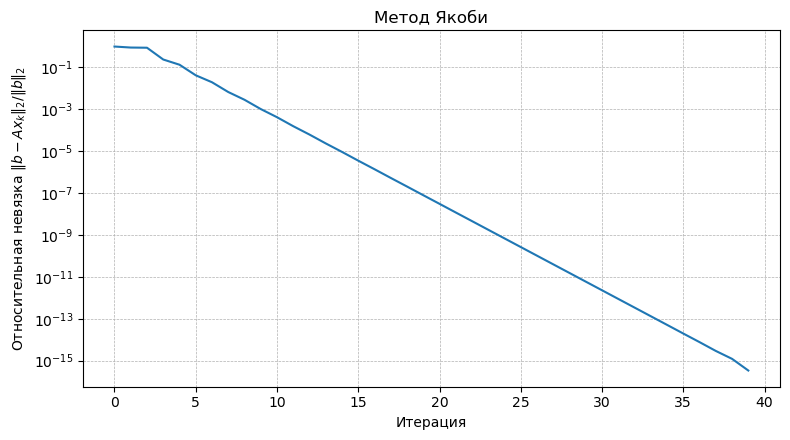

In [64]:
def jacobi_iter(rows, b, x0=None, tol=1e-15, max_iter=50000):
    n = len(rows)
    x = [0.0] * n if x0 is None else [float(v) for v in x0]

    diag = [0.0] * n
    for i in range(n):
        for j, aij in rows[i]:
            if j == i:
                diag[i] = aij
                break

    hist = []
    for _ in range(max_iter):
        rr = rel_res(rows, b, x)
        hist.append(rr)
        if rr < tol:
            break

        x_new = [0.0] * n
        for i in range(n):
            s = 0.0
            for j, aij in rows[i]:
                if j != i:
                    s += aij * x[j]
            x_new[i] = (b[i] - s) / diag[i]
        x = x_new

    return x, np.array(hist)

x_jac, h_jac = jacobi_iter(A_rows, b, x0=[0.0]*len(b), tol=1e-15, max_iter=50000)
print("Якоби: итераций =", len(h_jac) - 1, "финальная невязка =", h_jac[-1])
plot_history(h_jac, "Метод Якоби")

## 4) Метод Зейделя (Гаусса—Зейделя)

Отличие от Якоби: мы обновляем $x_i$ **сразу** и используем свежие значения в текущей итерации.

Зейдель: итераций = 16 финальная невязка = 5.197468354688782e-16


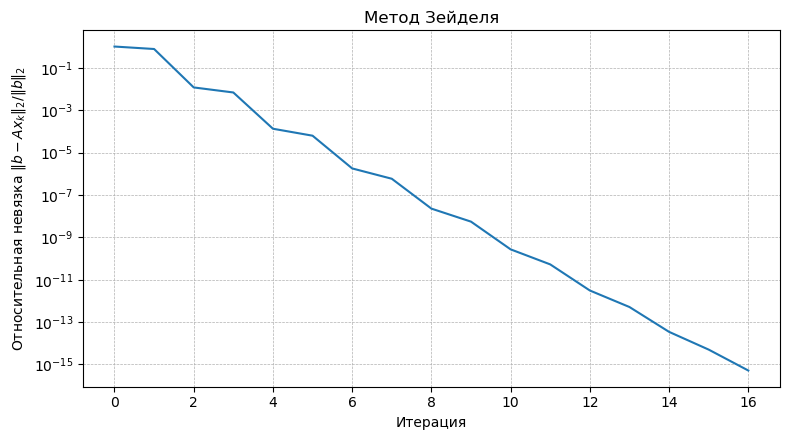

In [65]:
def seidel_iter(rows, b, x0=None, tol=1e-15, max_iter=50000):
    n = len(rows)
    x = [0.0] * n if x0 is None else [float(v) for v in x0]

    diag = [0.0] * n
    for i in range(n):
        for j, aij in rows[i]:
            if j == i:
                diag[i] = aij
                break

    hist = []
    for _ in range(max_iter):
        rr = rel_res(rows, b, x)
        hist.append(rr)
        if rr < tol:
            break

        for i in range(n):
            s = 0.0
            for j, aij in rows[i]:
                if j != i:
                    s += aij * x[j]
            x[i] = (b[i] - s) / diag[i]

    return x, np.array(hist)

x_gs, h_gs = seidel_iter(A_rows, b, x0=[0.0]*len(b), tol=1e-15, max_iter=50000)
print("Зейдель: итераций =", len(h_gs) - 1, "финальная невязка =", h_gs[-1])
plot_history(h_gs, "Метод Зейделя")

## 5) SOR (верхняя релаксация)

Это “ускоренный” Зейдель: после шага Зейделя делаем релаксацию с параметром $\omega$:

$$
x_i^{(k+1)} = (1-\omega)x_i^{(k)} + \omega x_{i,\text{GS}}^{(k+1)}, \qquad \omega\in(0,2).
$$

SOR(ω=1.05): итераций = 19 финальная невязка = 1.6381542323388726e-16


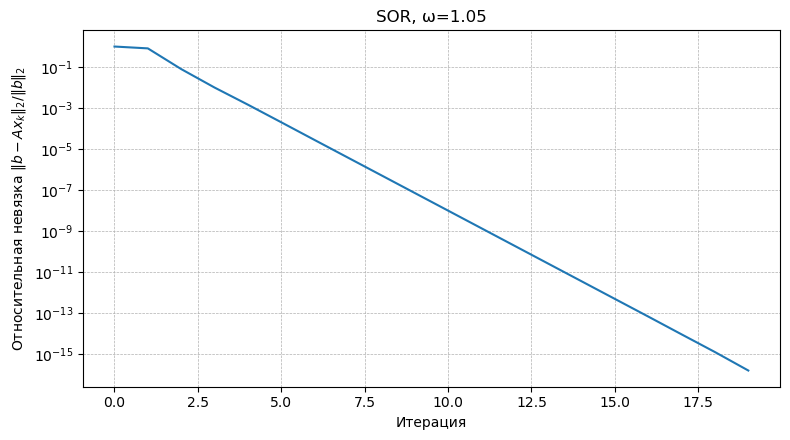

In [66]:
def sor_iter(rows, b, omega=1.05, x0=None, tol=1e-15, max_iter=50000):
    n = len(rows)
    x = [0.0] * n if x0 is None else [float(v) for v in x0]

    diag = [0.0] * n
    for i in range(n):
        for j, aij in rows[i]:
            if j == i:
                diag[i] = aij
                break

    hist = []
    for _ in range(max_iter):
        rr = rel_res(rows, b, x)
        hist.append(rr)
        if rr < tol:
            break

        for i in range(n):
            s = 0.0
            for j, aij in rows[i]:
                if j != i:
                    s += aij * x[j]
            x_gs = (b[i] - s) / diag[i]
            x[i] = (1.0 - omega) * x[i] + omega * x_gs

    return x, np.array(hist)

x_sor, h_sor = sor_iter(A_rows, b, omega=1.05, x0=[0.0]*len(b), tol=1e-15, max_iter=50000)
print("SOR(ω=1.05): итераций =", len(h_sor) - 1, "финальная невязка =", h_sor[-1])
plot_history(h_sor, "SOR, ω=1.05")

## 6) Градиентный спуск (НК)

Шаг:
$$
x_{k+1} = x_k + \alpha A^T r_k, \quad r_k=b-Ax_k.
$$

Град. спуск: итераций = 84799 финальная невязка = 9.999706783515821e-11


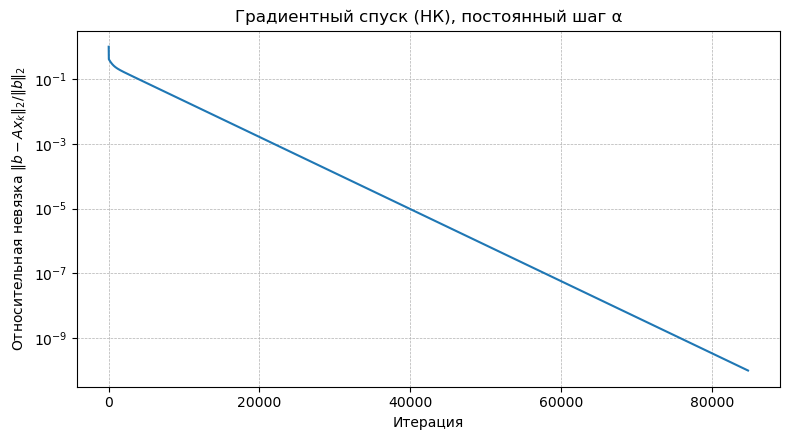

In [67]:
def grad_descent_ls(rows, b, alpha=1e-3, x0=None, tol=1e-10, max_iter=2_000_000):
    n = len(rows)
    x = [0.0] * n if x0 is None else [float(v) for v in x0]
    hist = []

    for _ in range(max_iter):
        rr = rel_res(rows, b, x)
        hist.append(rr)
        if rr < tol:
            break

        Ax = matvec_rows(rows, x)
        r = [b[i] - Ax[i] for i in range(n)]
        g = atvec_rows(rows, r)  # A^T r

        for i in range(n):
            x[i] += alpha * g[i]

    return x, np.array(hist)

x_gd, h_gd = grad_descent_ls(A_rows, b, alpha=1e-3, x0=[0.0]*len(b), tol=1e-10, max_iter=2_000_000)
print("Град. спуск: итераций =", len(h_gd) - 1, "финальная невязка =", h_gd[-1])
plot_history(h_gd, "Градиентный спуск (НК), постоянный шаг α")

## 7) Метод минимальных невязок (MR)

Берём шаг вдоль $r_k$ и выбираем $\alpha_k$ так, чтобы $\|r_{k+1}\|$ уменьшалась:

$$
x_{k+1}=x_k+\alpha_k r_k,\qquad
\alpha_k=\frac{(Ar_k,r_k)}{(Ar_k,Ar_k)}.
$$

MR: итераций = 199999 финальная невязка = 0.44317122873914616


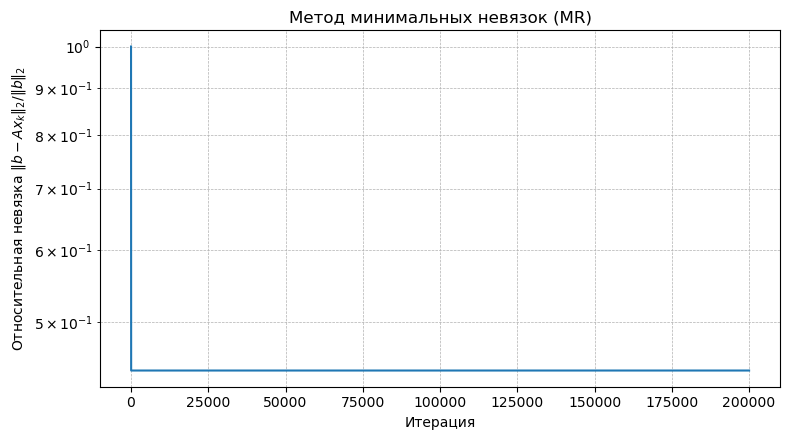

In [68]:
def minimal_residual(rows, b, x0=None, tol=1e-10, max_iter=200_000):
    n = len(rows)
    x = [0.0] * n if x0 is None else [float(v) for v in x0]
    hist = []

    for _ in range(max_iter):
        rr = rel_res(rows, b, x)
        hist.append(rr)
        if rr < tol:
            break

        Ax = matvec_rows(rows, x)
        r = [b[i] - Ax[i] for i in range(n)]
        Ar = matvec_rows(rows, r)

        num = sum(Ar[i] * r[i] for i in range(n))
        den = sum(Ar[i] * Ar[i] for i in range(n))
        if den == 0.0:
            break

        alpha = num / den
        for i in range(n):
            x[i] += alpha * r[i]

    return x, np.array(hist)

x_mr, h_mr = minimal_residual(A_rows, b, x0=[0.0]*len(b), tol=1e-10, max_iter=200_000)

print("MR: итераций =", len(h_mr)-1, "финальная невязка =", h_mr[-1])
plot_history(h_mr, "Метод минимальных невязок (MR)")


## 8) CGNR и BiCGSTAB

- **CGNR**: метод сопряжённых градиентов на нормальных уравнениях $A^TAx=A^Tb$.
- **BiCGSTAB**: метод Крылова для нессиметричных матриц.

CGNR: итераций = 33 финальная невязка = 9.04716029437873e-16


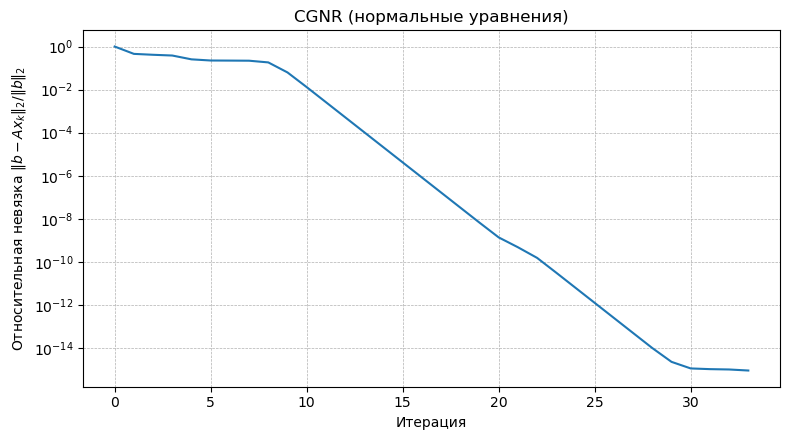

BiCGSTAB: итераций = 13 финальная невязка = 1.3622520683242741e-17


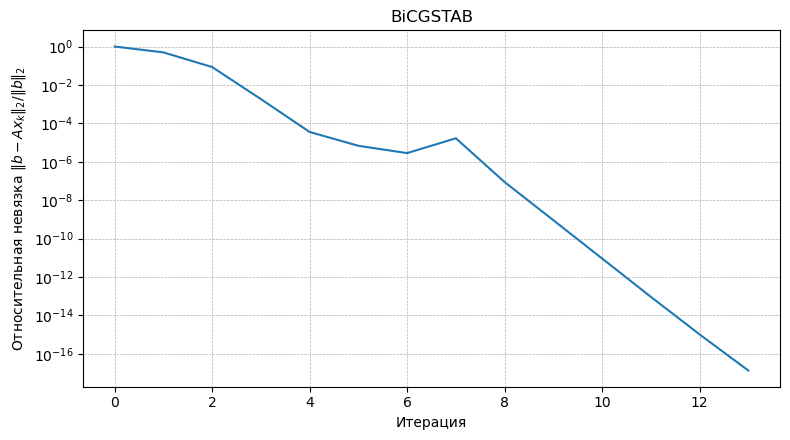

In [69]:
def cgnr(rows, b, x0=None, tol=1e-15, max_iter=200_000):
    n = len(rows)
    x = [0.0] * n if x0 is None else [float(v) for v in x0]

    Ax = matvec_rows(rows, x)
    r = [b[i] - Ax[i] for i in range(n)]
    z = atvec_rows(rows, r)
    p = z[:]
    zz = sum(zi * zi for zi in z)

    hist = [rel_res(rows, b, x)]

    for _ in range(max_iter):
        if hist[-1] < tol:
            break

        Ap = matvec_rows(rows, p)
        denom = sum(v * v for v in Ap)
        if denom == 0.0:
            break

        alpha = zz / denom
        for i in range(n):
            x[i] += alpha * p[i]
            r[i] -= alpha * Ap[i]

        z = atvec_rows(rows, r)
        zz_new = sum(zi * zi for zi in z)
        beta = 0.0 if zz == 0.0 else (zz_new / zz)

        for i in range(n):
            p[i] = z[i] + beta * p[i]
        zz = zz_new

        hist.append(rel_res(rows, b, x))

    return x, np.array(hist)


def bicgstab(rows, b, x0=None, tol=1e-15, max_iter=200_000):
    n = len(rows)
    x = [0.0] * n if x0 is None else [float(v) for v in x0]

    Ax = matvec_rows(rows, x)
    r = [b[i] - Ax[i] for i in range(n)]
    r_hat = r[:]

    rho_old = 1.0
    alpha = 1.0
    omega = 1.0

    v = [0.0] * n
    p = [0.0] * n

    hist = [rel_res(rows, b, x)]
    b_norm = (sum(float(bi) * float(bi) for bi in b) ** 0.5)

    for _ in range(max_iter):
        if hist[-1] < tol:
            break

        rho_new = sum(r_hat[i] * r[i] for i in range(n))
        if rho_new == 0.0:
            break

        beta = (rho_new / rho_old) * (alpha / omega)
        for i in range(n):
            p[i] = r[i] + beta * (p[i] - omega * v[i])

        v = matvec_rows(rows, p)
        denom = sum(r_hat[i] * v[i] for i in range(n))
        if denom == 0.0:
            break
        alpha = rho_new / denom

        s = [r[i] - alpha * v[i] for i in range(n)]
        s_norm = (sum(si * si for si in s) ** 0.5)
        if s_norm / b_norm < tol:
            for i in range(n):
                x[i] += alpha * p[i]
            hist.append(s_norm / b_norm)
            break

        t = matvec_rows(rows, s)
        tt = sum(ti * ti for ti in t)
        if tt == 0.0:
            break
        omega = sum(t[i] * s[i] for i in range(n)) / tt
        if omega == 0.0:
            break

        for i in range(n):
            x[i] += alpha * p[i] + omega * s[i]
            r[i] = s[i] - omega * t[i]

        rho_old = rho_new
        hist.append(rel_res(rows, b, x))

    return x, np.array(hist)


x_cgnr, h_cgnr = cgnr(A_rows, b, x0=[0.0]*len(b), tol=1e-15, max_iter=200_000)
print("CGNR: итераций =", len(h_cgnr) - 1, "финальная невязка =", h_cgnr[-1])
plot_history(h_cgnr, "CGNR (нормальные уравнения)")

x_bicg, h_bicg = bicgstab(A_rows, b, x0=[0.0]*len(b), tol=1e-15, max_iter=200_000)
print("BiCGSTAB: итераций =", len(h_bicg) - 1, "финальная невязка =", h_bicg[-1])
plot_history(h_bicg, "BiCGSTAB")

## Сравнение убывания невязки (первые 50 итераций)

Для наглядности сравним, как быстро падает относительная невязка у разных итерационных методов.

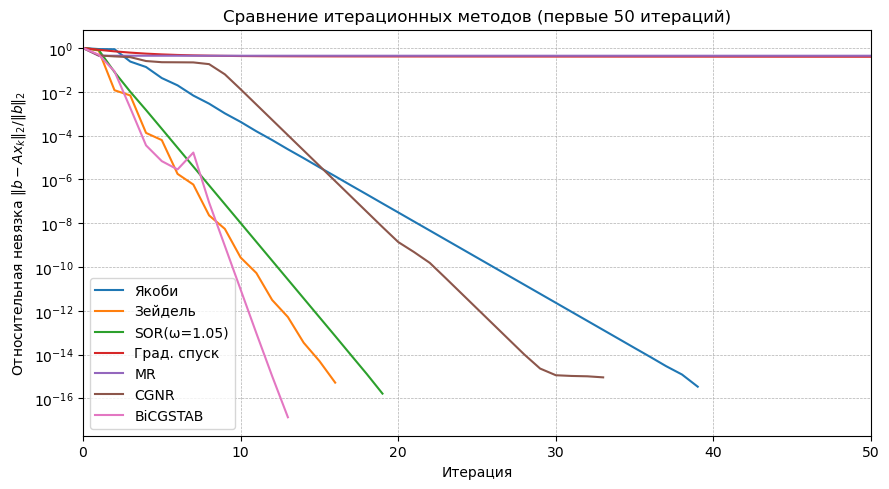

In [70]:
hist_map = {
    "Якоби": h_jac,
    "Зейдель": h_gs,
    "SOR(ω=1.05)": h_sor,
    "Град. спуск": h_gd,
    "MR": h_mr,
    "CGNR": h_cgnr,
    "BiCGSTAB": h_bicg,
}

kmax = 50
plt.figure(figsize=(9, 5))
for name, hist in hist_map.items():
    m = min(len(hist), kmax + 1)
    plt.semilogy(range(m), hist[:m], label=name)

plt.xlim(0, kmax)
plt.xlabel("Итерация")
plt.ylabel(r"Относительная невязка $\|b-Ax_k\|_2/\|b\|_2$")
plt.title("Сравнение итерационных методов (первые 50 итераций)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Результаты

Сравним:
- финальную относительную невязку;
- число итераций;
- разница с решением, найденным методом Гаусса;
- сколько итераций нужно, чтобы опуститься ниже $10^{-6}$ и $10^{-10}$.

In [71]:
import pandas as pd

def iters_to_tol(hist, tol):
    for i, v in enumerate(hist):
        if v <= tol:
            return i
    return -1

def l2_norm(vec):
    return float(sum(v*v for v in vec) ** 0.5)

rows = []

rows.append({
    "Метод": "Гаусс (с выбором)",
    "Тип": "прямой",
    "Итерации": 0,
    "Финальная невязка": rel_res(A_rows, b, x_gepp),
    "||x - x_gauss||2": 0.0,
    "min(невязка) на [0..50]": np.nan,
    "итерации до 1e-6": -1,
    "итерации до 1e-10": -1,
})

if x_lu is not None:
    rows.append({
        "Метод": "LU (с перестановками)",
        "Тип": "прямой",
        "Итерации": 0,
        "Финальная невязка": rel_res(A_rows, b, x_lu),
        "||x - x_gauss||2": l2_norm([x_lu[i] - x_gepp[i] for i in range(len(b))]),
        "min(невязка) на [0..50]": np.nan,
        "итерации до 1e-6": -1,
        "итерации до 1e-10": -1,
    })

iters_pack = {
    "Якоби": (x_jac, h_jac),
    "Зейдель": (x_gs, h_gs),
    "SOR(ω=1.05)": (x_sor, h_sor),
    "Град. спуск": (x_gd, h_gd),
    "MR": (x_mr, h_mr),
    "CGNR": (x_cgnr, h_cgnr),
    "BiCGSTAB": (x_bicg, h_bicg),
}

for name, (x, hist) in iters_pack.items():
    hist = np.asarray(hist, dtype=float)
    rows.append({
        "Метод": name,
        "Тип": "итерационный",
        "Итерации": int(len(hist) - 1),
        "Финальная невязка": float(hist[-1]),
        "||x - x_gauss||2": l2_norm([x[i] - x_gepp[i] for i in range(len(b))]),
        "min(невязка) на [0..50]": float(np.min(hist[:min(len(hist), 51)])),
        "итерации до 1e-6": int(iters_to_tol(hist, 1e-6)),
        "итерации до 1e-10": int(iters_to_tol(hist, 1e-10)),
    })

df = pd.DataFrame(rows)
df["__ord"] = df["Тип"].map({"прямой": 0, "итерационный": 1})
df = df.sort_values(["__ord", "Финальная невязка", "Итерации"]).drop(columns=["__ord"])
df

,Метод,Тип,Итерации,Финальная невязка,||x - x_gauss||2,min(невязка) на [0..50],итерации до 1e-6,итерации до 1e-10
0,Гаусс (с выбором),прямой,0,5.413932e-16,0.000000e+00,NaN,-1,-1
1,LU (с перестановками),прямой,0,5.413932e-16,0.000000e+00,NaN,-1,-1
8,BiCGSTAB,итерационный,13,1.362252e-17,6.640516e-14,1.362252e-17,8,10
4,SOR(ω=1.05),итерационный,19,1.638154e-16,6.591526e-14,1.638154e-16,8,13
2,Якоби,итерационный,39,3.390663e-16,3.866681e-14,3.390663e-16,17,27
3,Зейдель,итерационный,16,5.197468e-16,2.873040e-13,5.197468e-16,7,11
7,CGNR,итерационный,33,9.047160e-16,5.016877e-13,9.047160e-16,16,23
5,Град. спуск,итерационный,84799,9.999707e-11,1.149008e-07,3.990222e-01,48864,84799
6,MR,итерационный,199999,4.431712e-01,3.515412e+02,4.431712e-01,-1,-1


## Обсуждение

- **Прямые методы** (Гаусс, LU) дают решение сразу и довольно надежны.
- **Якоби** простой, но часто самый медленный из базовых итерационных.
- **Зейдель** обычно быстрее Якоби, потому что использует обновлённые значения сразу.
- **SOR** может ускорить Зейделя при удачном $\omega$.
- **Градиентный спуск** и **MR** простые, но могут требовать много итераций.
- **CGNR** и особенно **BiCGSTAB** часто сходятся быстрее, но сами алгоритмы сложнее.